# Upload Data


In [1]:
#upload file data

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download "jangedoo/utkface-new"

!unzip utkface-new.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104

# Setp environment / set data

In [2]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset_path = "/content/UTKFace"
image_size = 128
images = []
ages = []

for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg"):
        age = int(filename.split('_')[0])
        # Convert to GRAY to reduce the the complex of the data
        img = cv2.imread(os.path.join(dataset_path, filename), cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (image_size, image_size))
        images.append(img_resized)
        ages.append(age)

images = np.array(images)
ages = np.array(ages)

# Test data from
print(f"Shape of images: {images.shape}")
print(f"Shape of ages: {ages.shape}")

# Normalize images
images = images / 255.0

# Test Min/Max data
print(f"Min value in images: {images.min()}")
print(f"Max value in images: {images.max()}")

# Reshape images to fit MLP input
images = images.reshape(images.shape[0], -1)

# Check Shape of images
print(f"Shape of images after reshape: {images.shape}")

# Split the data to Training/ Validation --- 80%: Training / 20%: Validation
X_train, X_test, y_train, y_test = train_test_split(images, ages, test_size=0.2, random_state=42)


# Check shape of training/ validation
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Reshape images to fit MLP input (flatten each image to a 1D vector)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Kiểm tra các giá trị min và max sau khi chuẩn hóa với StandardScaler
print(f"Min value in X_train: {X_train.min()}")
print(f"Max value in X_train: {X_train.max()}")


Shape of images: (23708, 128, 128)
Shape of ages: (23708,)
Min value in images: 0.0
Max value in images: 1.0
Shape of images after reshape: (23708, 16384)
Shape of X_train: (18966, 16384)
Shape of X_test: (4742, 16384)
Shape of y_train: (18966,)
Shape of y_test: (4742,)
Min value in X_train: -4.604313614071827
Max value in X_train: 4.93270787333275


# Bulding model MLP

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              33556480  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

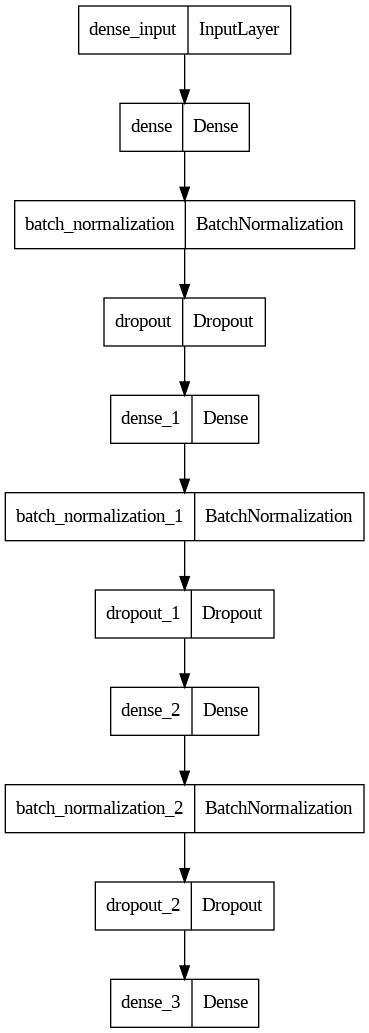

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Building MLP model
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(image_size * image_size,), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))


# reduce learning rate
optimizer = Adam(learning_rate=0.0001)
# Compile model
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])


# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



model.summary()
plot_model(model)


# Train Model

In [5]:
# Train Model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, verbose=1, callbacks=[reduce_lr, early_stopping])


Epoch 1/200
238/238 [==============================] - 10s 21ms/step - loss: 38.5610 - mae: 32.9402 - val_loss: 37.9586 - val_mae: 32.4384 - lr: 1.0000e-04
Epoch 2/200
238/238 [==============================] - 4s 17ms/step - loss: 37.6087 - mae: 32.1977 - val_loss: 36.9133 - val_mae: 31.6250 - lr: 1.0000e-04
Epoch 3/200
238/238 [==============================] - 4s 18ms/step - loss: 36.3249 - mae: 31.1521 - val_loss: 35.4881 - val_mae: 30.4437 - lr: 1.0000e-04
Epoch 4/200
238/238 [==============================] - 4s 18ms/step - loss: 34.5158 - mae: 29.5872 - val_loss: 33.1109 - val_mae: 28.3080 - lr: 1.0000e-04
Epoch 5/200
238/238 [==============================] - 4s 18ms/step - loss: 32.0847 - mae: 27.3892 - val_loss: 30.3942 - val_mae: 25.8157 - lr: 1.0000e-04
Epoch 6/200
238/238 [==============================] - 4s 17ms/step - loss: 28.7837 - mae: 24.2901 - val_loss: 26.0918 - val_mae: 21.6989 - lr: 1.0000e-04
Epoch 7/200
238/238 [==============================] - 4s 18ms/step -

# Evaluate model

In [6]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Mean Absolute Error on test set: {mae}')


Mean Absolute Error on test set: 7.2236785888671875


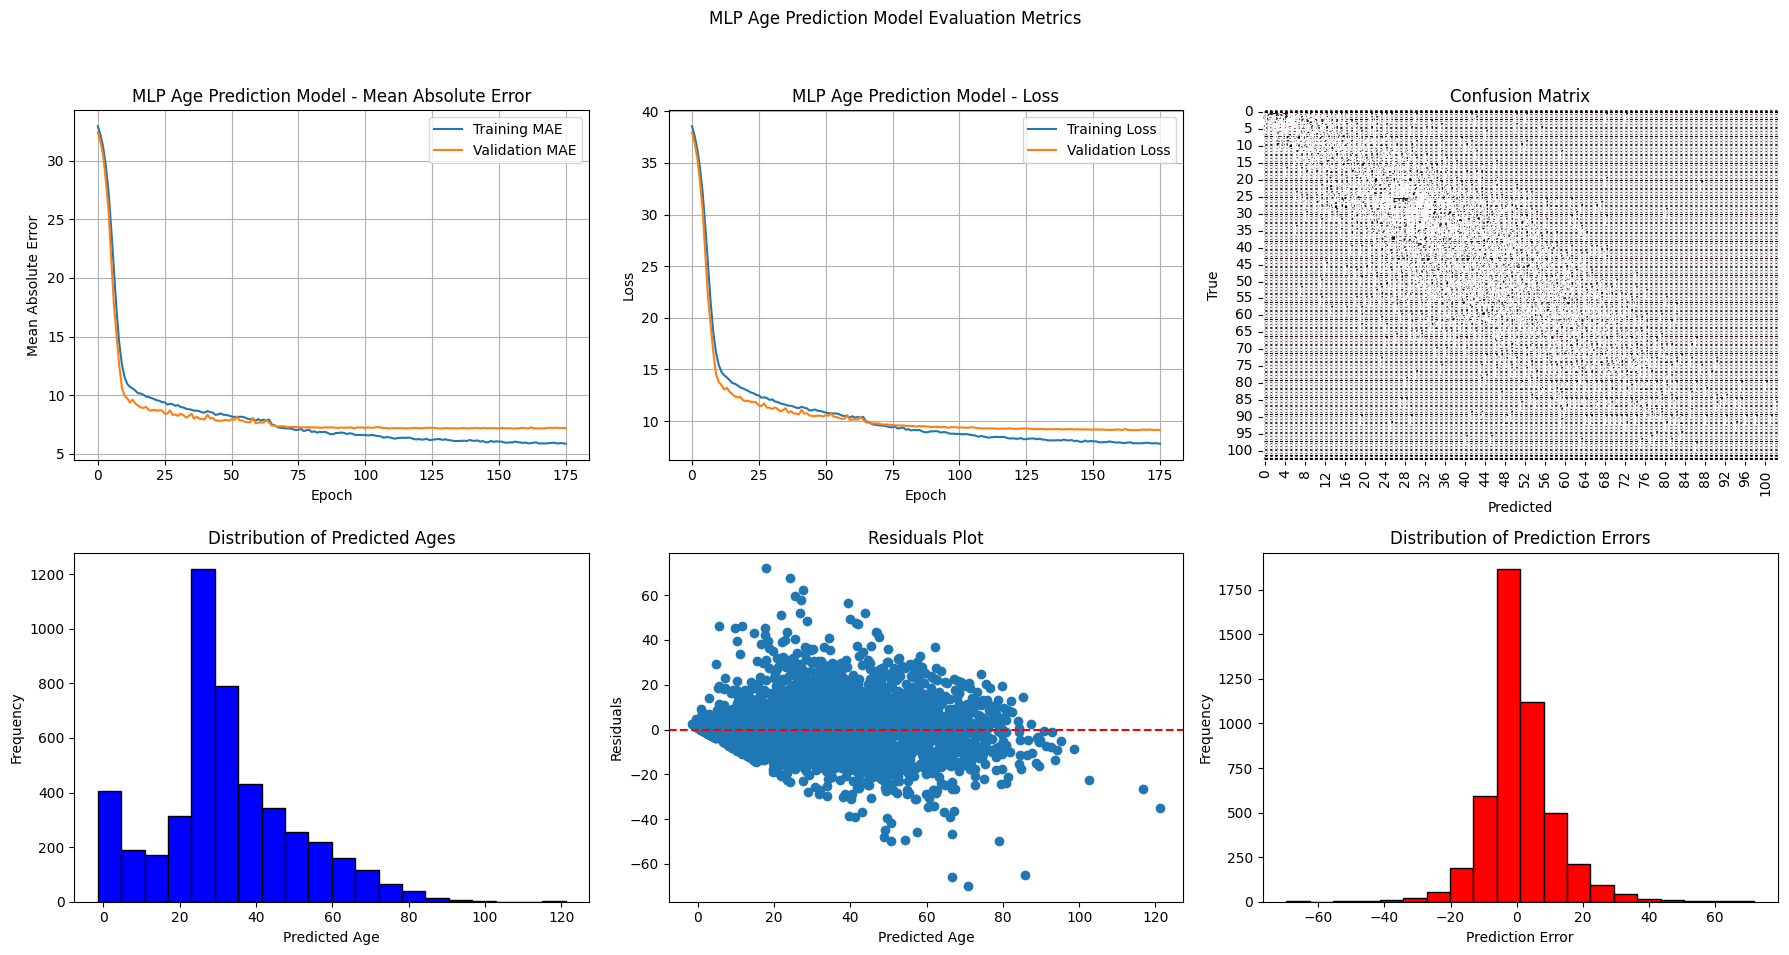

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Hàm vẽ các biểu đồ đánh giá mô hình
def plot_evaluation_metrics(history, y_test, y_pred, model_name):
    # Kiểm tra kích thước của y_test và y_pred
    if y_test.shape != y_pred.shape:
        print("Error: y_test and y_pred must have the same shape")
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Vẽ biểu đồ MAE
    axes[0, 0].plot(history.history['mae'], label='Training MAE')
    axes[0, 0].plot(history.history['val_mae'], label='Validation MAE')
    axes[0, 0].set_title(f'{model_name} - Mean Absolute Error')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Mean Absolute Error')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Vẽ biểu đồ Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title(f'{model_name} - Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Confusion Matrix
    y_pred_classes = np.round(y_pred).astype(int)
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='pink', ax=axes[0, 2], cbar=False, linewidths=0.5, linecolor='black')
    axes[0, 2].set_title('Confusion Matrix')
    axes[0, 2].set_xlabel('Predicted')
    axes[0, 2].set_ylabel('True')

    # Distribution of Predicted Values
    axes[1, 0].hist(y_pred, bins=20, color='blue', edgecolor='black')
    axes[1, 0].set_title('Distribution of Predicted Ages')
    axes[1, 0].set_xlabel('Predicted Age')
    axes[1, 0].set_ylabel('Frequency')

    # Residual Plot
    residuals = y_test - y_pred
    axes[1, 1].scatter(y_pred, residuals)
    axes[1, 1].set_title('Residuals Plot')
    axes[1, 1].set_xlabel('Predicted Age')
    axes[1, 1].set_ylabel('Residuals')
    axes[1, 1].axhline(0, color='red', linestyle='--')

    # Distribution of Prediction Errors
    errors = y_test - y_pred
    axes[1, 2].hist(errors, bins=20, color='red', edgecolor='black')
    axes[1, 2].set_title('Distribution of Prediction Errors')
    axes[1, 2].set_xlabel('Prediction Error')
    axes[1, 2].set_ylabel('Frequency')

    plt.suptitle(f'{model_name} Evaluation Metrics')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Lưu biểu đồ thành tệp
    fig.savefig(f'{model_name}_evaluation_metrics.png')


# # Dự đoán tuổi trên tập kiểm tra (nếu chưa làm trước đó)
y_pred = y_pred.flatten()

# Kiểm tra lại kích thước của y_pred
# print(f'Shape of y_pred after flatten: {y_pred.shape}')

# Gọi hàm để vẽ các biểu đồ đánh giá
plot_evaluation_metrics(history, y_test, y_pred, 'MLP Age Prediction Model')


# Graph/ output after training

# Testing

149/149 [==============================] - 0s 2ms/step


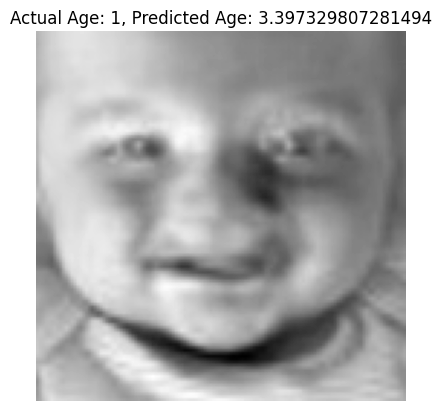

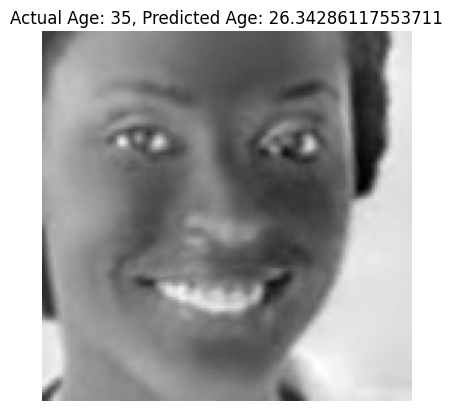

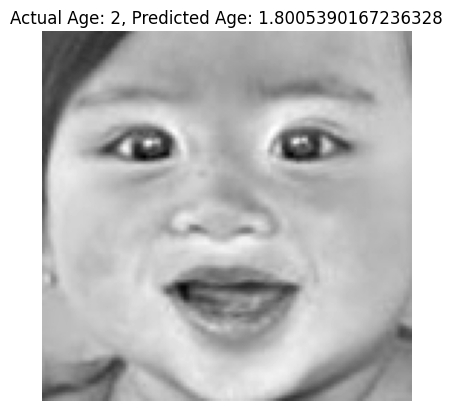

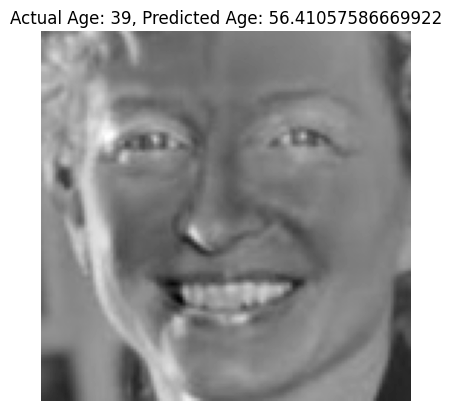

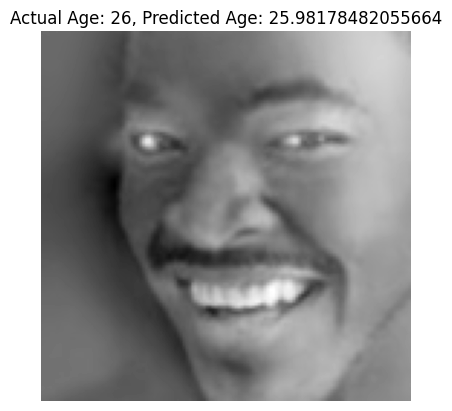

In [41]:
# Dự đoán tuổi trên tập kiểm tra
y_pred = model.predict(X_test)
# Hiển thị một số kết quả
for i in range(60, 65):
    plt.imshow(X_test[i].reshape(image_size, image_size), cmap='gray')
    plt.title(f'Actual Age: {y_test[i]}, Predicted Age: {y_pred[i][0]}')
    plt.axis('off')
    plt.show()